In [26]:
## Imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import glob
import os
import requests
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.externals import *
from dateutil.parser import parse
import datetime as dt

# Exploration
#### This notebook outlines initial exploration of the dataset.

## Task 1: Explore subjects feature
We want to answer some basic questions about the subject feature. This might expose interesting topics to analyze in greater depth. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique subjects. How many different subjects are there? (what level of granularity are we getting here?)
- Find which subjects have more than 100 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [27]:
## Define paths
DATA_FOLDER = './liar_dataset/'
DATA_PATH = DATA_FOLDER + 'train.tsv'

In [28]:
## Load raw data
cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
df_raw = pd.read_table(DATA_PATH, header=None)
df_raw.columns = cols
df_raw.head(2)

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [29]:
## Check types and shape
print(df_raw.dtypes)
print(df_raw.shape)

ID                    object
label                 object
statement             object
subject               object
speaker               object
job                   object
state                 object
party                 object
barely_true_cts      float64
false_cts            float64
half_true_cts        float64
mostly_true_cts      float64
pants_on_fire_cts    float64
context               object
dtype: object
(10240, 14)


In [30]:
## Help put data in useful form - split topics as list and separate into new rows for grouping
## Split subjects into lists
subject_split = df_raw.copy()
subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
subject_split.head(2)

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [31]:
set_of_subjects = set()
for subject_list in subject_split['subject'].values:
    set_of_subjects |= set(subject_list)
    
print("There are %d unique subjects" % len(set_of_subjects))
print("Some sample subjects include:\n", list(set_of_subjects)[:5])

There are 143 unique subjects
Some sample subjects include:
 ['environment', 'occupy-wall-street', 'diversity', 'natural-disasters', 'income']


In [32]:
## Create a dataframe of all subjects
subjects = subject_split.subject.apply(pd.Series)
new_cols = cols.copy()
new_cols.remove("subject")

## Now merge with original frame to create separate columns for each subject
## Then melt so that each entry exists under several subjects
subject_split = subjects.merge(subject_split, right_index = True, left_index = True) \
    .drop(["subject"], axis = 1) \
    .melt(id_vars = new_cols, value_name = "subject") \
    .drop("variable", axis = 1) \
    .dropna()

subject_split.head(2)

,ID,label,statement,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,subject
0,2635.json,false,Says the Annies List political group supports ...,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,abortion
1,10540.json,half-true,When did the decline of coal start? It started...,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,energy


We notice that many subjects have very few instances within the dataset. 
We want to limit ourselves to subjects that are mentioned with reasonable frequency.
We choose to only include subjects that appear more than 100 times.

In [33]:
subject_counts = subject_split.groupby("subject").count()
subjects_over_100 = subject_counts.where(subject_counts['ID'] > 100).dropna().index
subject_split = subject_split[subject_split['subject'].isin(subjects_over_100)]

print("There are %d unique subjects that have over 100 corresponding statements" % len(subjects_over_100))

There are 44 unique subjects that have over 100 corresponding statements


By limiting out subjects to those that appear frequently, we have a small enough set to do some useful visual analysis.

In [34]:
def by_label(df, column):
    return df.groupby([column,"label"]).agg({"ID" : "count"})

breakdown = by_label(subject_split, 'subject')
breakdown.head()

ID
subject  label          
abortion barely-true  30
         false        23
         half-true    31
         mostly-true  20
         pants-fire   10

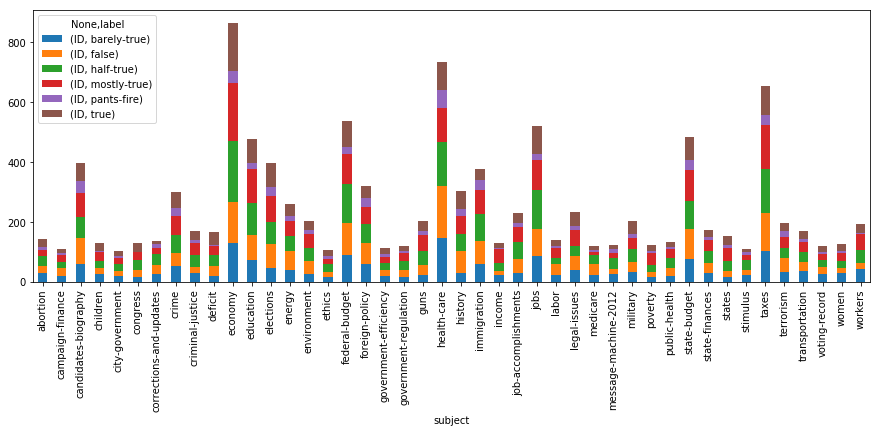

In [35]:
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [36]:
def normalize(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return bd_norm

bd_norm = normalize(breakdown, 'subject')

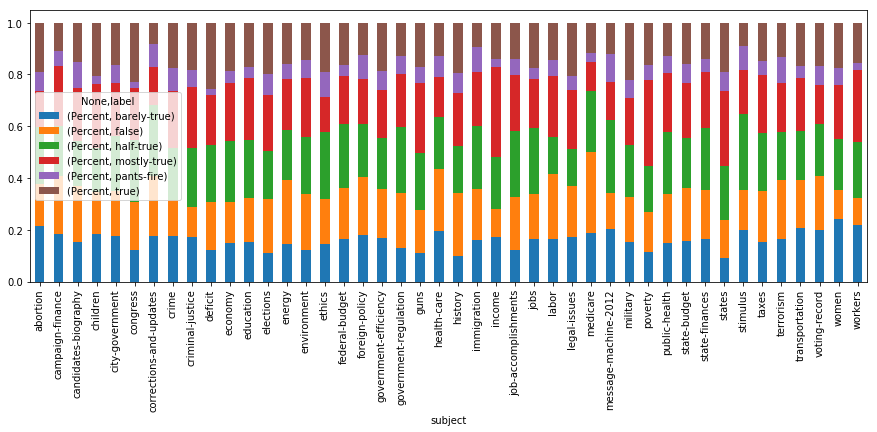

In [37]:
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

Above, we can see from our un-normalized plot the distribution of topics as well as their respective distribution of truth classifications. From the normalized plot, we see can more easily see the distribution of truth classifications.

We may be interested in making a simpler classification, such as 'false' versus 'not false'. In this way, we regard 'pants-fire' and 'false' as a false tags, and all others are those statements with at least a small degree of truth within.

In [38]:
def transform_tf(df, column):
    tf_breakdown = df.copy()
    tf_breakdown['false'] = ~(tf_breakdown['label'].isin(['false', 'pants-fire']))

    tf_breakdown = tf_breakdown.groupby([column,"false"]).agg({"ID" : "count"})
    return tf_breakdown

tf_breakdown = transform_tf(subject_split, 'subject')

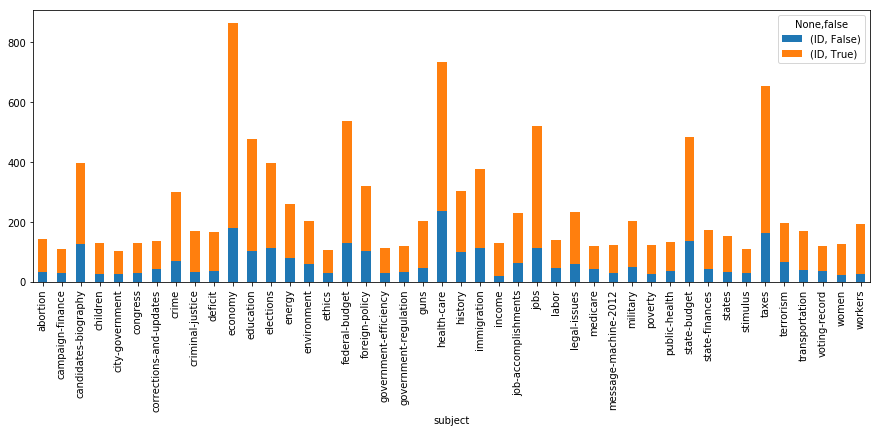

In [39]:
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [40]:
def normalize_tf(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'false'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'false'])
    return bd_norm

bd_norm = normalize_tf(tf_breakdown, 'subject')
bd_norm.head()

Percent
subject              false          
abortion             False  0.234043
                     True   0.765957
campaign-finance     False  0.277778
                     True   0.722222
candidates-biography False  0.314861

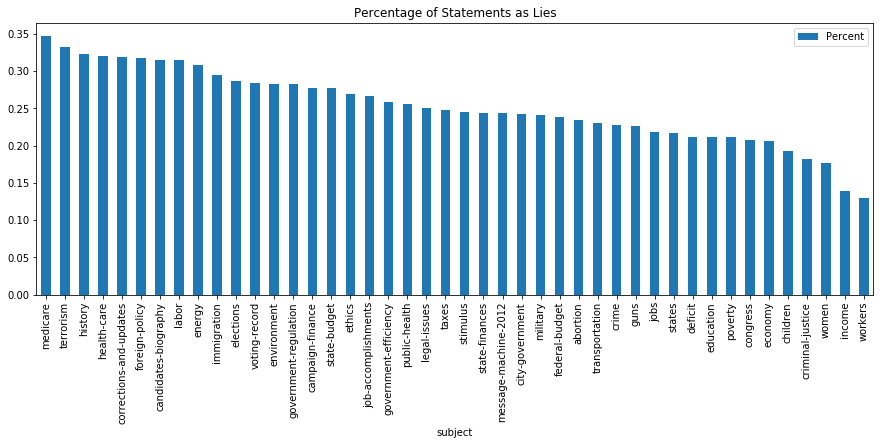

In [41]:
def plot_truthfulness(df, column):
    df_ri = df.reset_index()
    tf = df_ri[~df_ri['false']][[column, 'Percent']]
    tf = tf.sort_values('Percent', ascending=False)
    tf.plot(x=column,kind='bar', title="Percentage of Statements as Lies", figsize=(15,5))
    
plot_truthfulness(bd_norm, "subject")

### Task 1: Interpretation
We note that of the topics discussed often in the liar dataset, medicare and terrorism have the most lies. While we note the percentages are quite high, we note that statements from this dataset are by dy default disputed so this is not unexpected. However, assuming the dataset was not gathered with a particularly subject bias, the relative truth rate between subjects could be meaningful. It is possibly worth looking in to Note that this analysis does not consider consider half-true as a lie.

## Task 2: Explore speaker feature
We want to answer some basic questions about the speaker feature. This might expose interesting topics to analyze in greater depth because it is likely that different speakers have different levels of truthfulness. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique speakers. How many different speakers are there?
- Find which speakers have more than 50 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [42]:
speakers_df = df_raw.copy()
speakers = speakers_df['speaker'].unique()
print("There are %d unique speakers" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 2911 unique speakers
Some sample speakers include:
 ['dwayne-bohac' 'scott-surovell' 'barack-obama' 'blog-posting'
 'charlie-crist']


In [43]:
speakers_cts = speakers_df.groupby("speaker").statement.count()
speakers = speakers_cts[speakers_cts > 50]
print("There are %d unique speakers who appear more than 50 times within the dataset" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 21 unique speakers who appear more than 50 times within the dataset
Some sample speakers include:
 speaker
barack-obama     488
bernie-s          88
blog-posting      59
chain-email      142
charlie-crist     70
Name: statement, dtype: int64


In [44]:
## Limit ourselves to only prominent speakers for visualization
speakers_df = speakers_df[speakers_df['speaker'].isin(speakers.keys())]

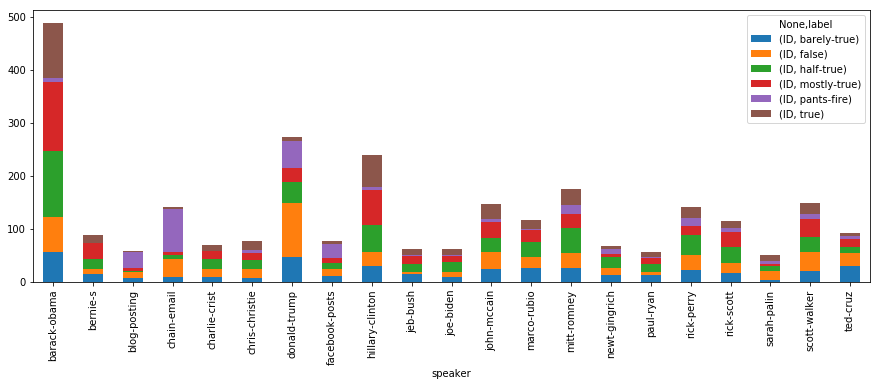

In [45]:
breakdown = by_label(speakers_df, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

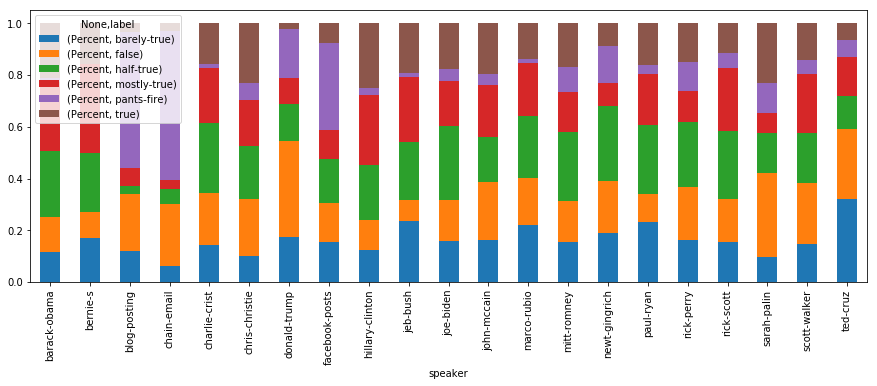

In [46]:
bd_norm = normalize(breakdown, 'speaker')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

From this, we can see a few interesting findings. It seems that Facebook posts, chain emails and Donald Trump are trastically more likely to be 'pants-fire' lies, which are the most obvious and blatantly false types of lies of the possible labels. We also see that most other speakers maintain a very much smaller 'pants-fire' rate.

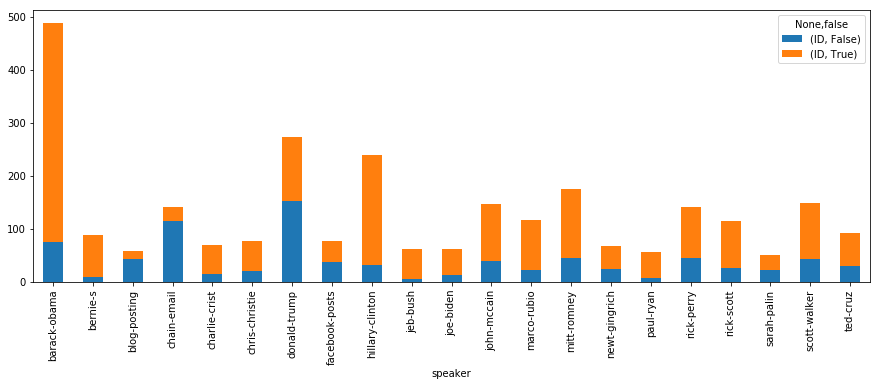

In [47]:
tf_breakdown = transform_tf(speakers_df, 'speaker')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

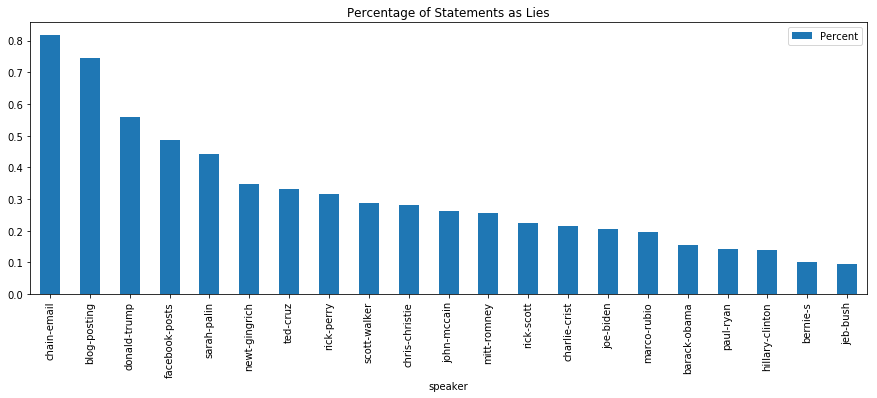

In [48]:
bd_norm = normalize_tf(tf_breakdown, 'speaker')
plot_truthfulness(bd_norm, 'speaker')

### Task 2: Interpretation
In breaking down our dataset by the speakers, we see some interesting trends, due to the fact that speakers can be both people as well as websites/communication mediums. In looking at our most prominent sources, we see that anonymous media tend to have the highest untruthfulness rate. The only person who who lies more than one of the anonymous media is Donald Trump, whose overall rate of lying is greater than Facebook posts. That said, we also see that Facebook posts proportionally are more 'pants-fire' type lies. Donald Trump has proportionally fewer 'pants-fire' lies, but drastically more 'false' lies.

We also note that chain-emails are heinously untruthful. Of the ones examined in this dataset, over 80% are either false or 'pants-fire' false.

## Task 3: Locational analysis
We note that our dataframe has state information for each of the statements. We would like to see how the rate of lies varies within states by:
- Creating a heatmap of lies from the dataset.

In [108]:
# Computing percentage of lies

states_lies_count = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby('state').state.count()
states_count = df_raw.groupby('state').state.count()
states_tot_false = pd.concat([states_count, states_lies_count], axis=1, sort=True).dropna()
states_tot_false.columns = ['count_tot', 'count_false']
states_tot_false.count_false = states_tot_false.count_false.astype('int64')
states_tot_false['perc_lies'] = (states_tot_false.count_false / states_tot_false.count_tot) * 100
states_tot_false.reset_index(inplace=True)
states_tot_false.columns = ['state', 'count_tot', 'count_false', 'perc_lies']
states_tot_false.head()

,state,count_tot,count_false,perc_lies
0,Alabama,14,4,28.571429
1,Alaska,65,28,43.076923
2,Arizona,182,47,25.824176
3,Arkansas,84,14,16.666667
4,California,159,42,26.415094


In [113]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

get_state_names = lambda x: x['properties']['name']
geo_states = set(map(get_state_names, geo_json_data['features']))
df_states = set(states_tot_false['state'])
to_add = geo_states - df_states

In [112]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_tot_false,
             columns=['state', 'perc_lies'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of lies (%)')
us_map

### Task 3: Interpretation
From here we see lies being more prominent in Montana than anywhere else, while Tennessee, Mississippi, West Virginia also are prominent. Ultimately, we do not see much geographical clustering, and even if we thought to note the general trend for higher lie rate in southern states, this does not seem to hold very well considering Arkansas and North Carolina. This may ultimately just be a heatmap of the states of the political speakers within the dataset, so this may not be useful in our further analysis.